In [20]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage import io, transform
import torch.nn as nn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.optim as optim
import torch.backends.cudnn as cudnn
import time
from progress.bar import Bar
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [21]:
class HandKeypointDataset(Dataset):
    """OpenPose Hand Landmarks dataset."""
    
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.landmark_paths = [i for i in os.listdir(self.root) if i.endswith(".json")]
        self.img_paths = [i[0:-5]+".jpg" for i in self.landmark_paths]
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = os.path.join(self.root, self.img_paths[idx])
        image = io.imread(img_path)
        
        landmark_path = os.path.join(self.root, self.landmark_paths[idx])
        landmark_data = json.load(open(landmark_path, 'r'))
        landmark_points = np.array(landmark_data['hand_pts'])[:,:2]
        landmarks = landmark_points.astype('float')
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [22]:
hand_keypoint_dataset = HandKeypointDataset(root="../datasets/KeypointDataset/")

In [23]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

0 (1024, 1024, 3) (21, 2)
1 (368, 368, 3) (21, 2)
2 (368, 368, 3) (21, 2)
3 (368, 368, 3) (21, 2)


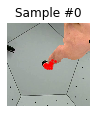

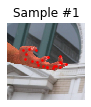

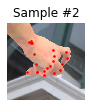

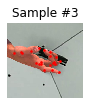

In [24]:
fig = plt.figure()

for i in range(len(hand_keypoint_dataset)):
    sample = hand_keypoint_dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break

In [25]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}
    

class ModifiedNormalize(object):
    """Normalize ndarrays in sample, keep labels as same."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = transforms.functional.normalize(image, mean=(0.5, 0.5, 0.5),std=(0.5, 0.5, 0.5))
        return {'image': image,
                'landmarks': landmarks}

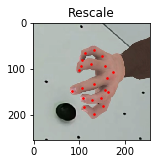

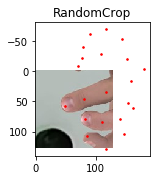

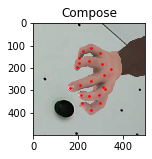

In [26]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(512),
                               RandomCrop(500)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = hand_keypoint_dataset[35]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [27]:
hand_keypoint_dataset = HandKeypointDataset(root="../datasets/KeypointDataset/", 
                                            transform=transforms.Compose([Rescale((512,512)),
                                                                          ToTensor(),
                                                                          ModifiedNormalize()
                                                                          ]))

for i in range(len(hand_keypoint_dataset)):
    sample = hand_keypoint_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 512, 512]) torch.Size([21, 2])
1 torch.Size([3, 512, 512]) torch.Size([21, 2])
2 torch.Size([3, 512, 512]) torch.Size([21, 2])
3 torch.Size([3, 512, 512]) torch.Size([21, 2])


In [28]:
dataloader = DataLoader(hand_keypoint_dataset, batch_size=4, shuffle=True, num_workers=0)

0 torch.Size([4, 3, 512, 512]) torch.Size([4, 21, 2])
1 torch.Size([4, 3, 512, 512]) torch.Size([4, 21, 2])
2 torch.Size([4, 3, 512, 512]) torch.Size([4, 21, 2])
3 torch.Size([4, 3, 512, 512]) torch.Size([4, 21, 2])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


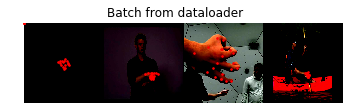

In [29]:
# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size + (i + 1) * grid_border_size,
                    landmarks_batch[i, :, 1].numpy() + grid_border_size,
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break

In [30]:
class KeyNet(nn.Module):
    def __init__(self,num_classes):
        super(KeyNet, self).__init__()
        self.net = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)
        self.pooling  = nn.AvgPool2d(3)
        self.fc = nn.Linear(512,num_classes)
    def forward(self,x):
        x = self.net(x)
        x = self.pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [31]:
use_cuda = torch.cuda.is_available()
use_cuda

True

In [32]:
model = KeyNet(21)
model = torch.nn.DataParallel(model).cuda()

In [33]:
criterion = nn.SmoothL1Loss().cuda()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [34]:
use_cuda = torch.cuda.is_available()
best_acc= 999

In [35]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [36]:
def train(trainloader, model, criterion, optimizer, epoch, use_cuda):
    # switch to train mode
    model.train()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    NormMS = AverageMeter()
    end = time.time()

    bar = Bar('Processing', max=len(trainloader))
    for batch_idx, batch_data in enumerate(trainloader):
        # measure data loading time
        data_time.update(time.time() - end)
        inputs = batch_data['image']
        targets = batch_data['landmarks']
        if use_cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        #nms= normalizedME(outputs.data,targets.data,64,64)
        losses.update(loss.data[0], inputs.size(0))
        #NormMS.update(nms[0], inputs.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return (losses.avg,0)




In [37]:
def test(testloader, model, criterion, epoch, use_cuda):
    global best_acc

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar('Processing', max=len(testloader))
    for batch_idx, batch_data in enumerate(testloader):
        # measure data loading time
        data_time.update(time.time() - end)

        inputs = batch_data['image']
        targets = batch_data['landmarks']
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        losses.update(loss.data[0], inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} '.format(
                    batch=batch_idx + 1,
                    size=len(testloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return (losses.avg,0)

In [38]:
for epoch in range(100):

        print('\nEpoch: [%d | %d]' % (epoch + 1, 100))

        train_loss, train_acc = train(dataloader, model, criterion, optimizer, epoch, use_cuda)
        test_loss, test_acc = test(dataloader, model, criterion, epoch, use_cuda)

        # # append logger file
        # logger.append([state['lr'], train_loss, test_loss, train_acc, test_acc])

        # save model
        is_best = test_loss <best_acc
        best_acc =min(test_loss, best_acc)
        # save_checkpoint({
        #         'epoch': epoch + 1,
        #         'state_dict': model.state_dict(),
        #         'acc': test_acc,
        #         'best_acc': best_acc,
        #         'optimizer' : optimizer.state_dict(),
        #     }, is_best, checkpoint=args.checkpoint,filename=title+'_'+str(epoch)+'.pth.tar')



Epoch: [1 | 100]


ValueError: In training mode, targets should be passed

In [39]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def train(trainloader, model, criterion, optimizer, epoch, use_cuda):
    
    # switch to train mode
    model.train()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    NormMS = AverageMeter()
    end = time.time()

    bar = Bar('Processing', max=len(trainloader))
    for batch_idx, batch_data in enumerate(trainloader):
        # measure data loading time
        data_time.update(time.time() - end)
        inputs = batch_data['image']
        targets = batch_data['landmarks']
        if use_cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        #nms= normalizedME(outputs.data,targets.data,64,64)
        losses.update(loss.data[0], inputs.size(0))
        #NormMS.update(nms[0], inputs.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return (losses.avg,0)




In [ ]:
def test(testloader, model, criterion, epoch, use_cuda):
    global best_acc

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar('Processing', max=len(testloader))
    for batch_idx, batch_data in enumerate(testloader):
        # measure data loading time
        data_time.update(time.time() - end)

        inputs = batch_data['image']
        targets = batch_data['landmarks']
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        losses.update(loss.data[0], inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} '.format(
                    batch=batch_idx + 1,
                    size=len(testloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return (losses.avg,0)

In [ ]:
for epoch in range(100):

        print('\nEpoch: [%d | %d]' % (epoch + 1, 100))

        train_loss, train_acc = train(dataloader, model, criterion, optimizer, epoch, use_cuda)
        test_loss, test_acc = test(dataloader, model, criterion, epoch, use_cuda)

        # append logger file
        logger.append([state['lr'], train_loss, test_loss, train_acc, test_acc])

        # save model
        is_best = test_loss <best_acc
        best_acc =min(test_loss, best_acc)
        save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'acc': test_acc,
                'best_acc': best_acc,
                'optimizer' : optimizer.state_dict(),
            }, is_best, checkpoint=args.checkpoint,filename=title+'_'+str(epoch)+'.pth.tar')


In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        ## TODO: Define all the layers of this CNN, the only requirements are:
        ## 1. This network takes in a square (same width and height), grayscale image as input
        ## 2. It ends with a linear layer that represents the keypoints
        ## it's suggested that you make this last layer output 136 values, 2 for each of the 68 keypoint (x, y) pairs
        
        # As an example, you've been given a convolutional layer, which you may (but don't have to) change:
        # 1 input image channel (grayscale), 32 output channels/feature maps, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1, 32, 5)
        
        ## Note that among the layers to add, consider including:
        # maxpooling layers, multiple conv layers, fully-connected layers, and other layers (such as dropout or batch normalization) to avoid overfitting
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32,64,3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64,128,3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128,256,3)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256,512,1)
        self.pool5 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(512*6*6, 1024)
        self.fc2 = nn.Linear(1024, 136)
        

        self.drop1 = nn.Dropout(p = 0.1)
        self.drop2 = nn.Dropout(p = 0.2)
        self.drop3 = nn.Dropout(p = 0.25)
        self.drop4 = nn.Dropout(p = 0.25)
        self.drop5 = nn.Dropout(p = 0.3)
        self.drop6 = nn.Dropout(p = 0.4)
        
        
    def forward(self, x):
        ## TODO: Define the feedforward behavior of this model
        ## x is the input image and, as an example, here you may choose to include a pool/conv step:
        ## x = self.pool(F.relu(self.conv1(x)))
      
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.drop1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.drop2(x)
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.drop3(x)
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.drop4(x)
        x = self.pool5(F.relu(self.conv5(x)))
        x = self.drop5(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop6(x)
        x = self.fc2(x)
        # a modified x, having gone through all the layers of your model, should be returned
        return x

In [35]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [36]:
def train(trainloader, model, criterion, optimizer, epoch, use_cuda):
    # switch to train mode
    model.train()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    NormMS = AverageMeter()
    end = time.time()

    bar = Bar('Processing', max=len(trainloader))
    for batch_idx, batch_data in enumerate(trainloader):
        # measure data loading time
        data_time.update(time.time() - end)
        inputs = batch_data['image']
        targets = batch_data['landmarks']
        if use_cuda:
            inputs = inputs.cuda()
            targets = targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        #nms= normalizedME(outputs.data,targets.data,64,64)
        losses.update(loss.data[0], inputs.size(0))
        #NormMS.update(nms[0], inputs.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f}'.format(
                    batch=batch_idx + 1,
                    size=len(trainloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return (losses.avg,0)




In [37]:
def test(testloader, model, criterion, epoch, use_cuda):
    global best_acc

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    bar = Bar('Processing', max=len(testloader))
    for batch_idx, batch_data in enumerate(testloader):
        # measure data loading time
        data_time.update(time.time() - end)

        inputs = batch_data['image']
        targets = batch_data['landmarks']
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

        # compute output
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # measure accuracy and record loss
        losses.update(loss.data[0], inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        bar.suffix  = '({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} '.format(
                    batch=batch_idx + 1,
                    size=len(testloader),
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    )
        bar.next()
    bar.finish()
    return (losses.avg,0)

In [38]:
for epoch in range(100):

        print('\nEpoch: [%d | %d]' % (epoch + 1, 100))

        train_loss, train_acc = train(dataloader, model, criterion, optimizer, epoch, use_cuda)
        test_loss, test_acc = test(dataloader, model, criterion, epoch, use_cuda)

        # append logger file
        logger.append([state['lr'], train_loss, test_loss, train_acc, test_acc])

        # save model
        is_best = test_loss <best_acc
        best_acc =min(test_loss, best_acc)
        save_checkpoint({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'acc': test_acc,
                'best_acc': best_acc,
                'optimizer' : optimizer.state_dict(),
            }, is_best, checkpoint=args.checkpoint,filename=title+'_'+str(epoch)+'.pth.tar')



Epoch: [1 | 100]


ValueError: In training mode, targets should be passed

In [39]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        ## TODO: Define all the layers of this CNN, the only requirements are:
        ## 1. This network takes in a square (same width and height), grayscale image as input
        ## 2. It ends with a linear layer that represents the keypoints
        ## it's suggested that you make this last layer output 136 values, 2 for each of the 68 keypoint (x, y) pairs
        
        # As an example, you've been given a convolutional layer, which you may (but don't have to) change:
        # 1 input image channel (grayscale), 32 output channels/feature maps, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1, 32, 5)
        
        ## Note that among the layers to add, consider including:
        # maxpooling layers, multiple conv layers, fully-connected layers, and other layers (such as dropout or batch normalization) to avoid overfitting
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32,64,3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64,128,3)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128,256,3)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(256,512,1)
        self.pool5 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(512*6*6, 1024)
        self.fc2 = nn.Linear(1024, 136)
        

        self.drop1 = nn.Dropout(p = 0.1)
        self.drop2 = nn.Dropout(p = 0.2)
        self.drop3 = nn.Dropout(p = 0.25)
        self.drop4 = nn.Dropout(p = 0.25)
        self.drop5 = nn.Dropout(p = 0.3)
        self.drop6 = nn.Dropout(p = 0.4)
        
        
    def forward(self, x):
        ## TODO: Define the feedforward behavior of this model
        ## x is the input image and, as an example, here you may choose to include a pool/conv step:
        ## x = self.pool(F.relu(self.conv1(x)))
      
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.drop1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.drop2(x)
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.drop3(x)
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.drop4(x)
        x = self.pool5(F.relu(self.conv5(x)))
        x = self.drop5(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop6(x)
        x = self.fc2(x)
        # a modified x, having gone through all the layers of your model, should be returned
        return x